# Encoder-Decoder Architecture (Machine Translation Example)

In the previous example, we saw the primitive text generation example with RNN, in which each word is selected only by the previous sequence of words.<br>
But, in real text generation, the word will be often decided with other information (context) - i.e, conditioned text generation.

Let's see the following architecture.<br>
In this architecture, the word is selected by both the sequence of words and context information ```c```.<br>
For instance, when it generates text for movie review, the conditioned context ```c``` might be a movie. When it generates the answer for questioning, it might be genre - such as, "computer science", "sports", "politics", etc. It will then be able to generate more appropriate text depending on the genre (theme) of the contents. 

![RNN with conditioned context](./images/conditioned_context.png)

The encoder-decoder framework is a trainer for text generation with **sequence-to-sequence** conditioned context as follows. (See the following diagram.)

For instance, when you want to translate French to English, first it generates conditioned context ```c``` from a source sentence (which is the sequence of length m).<br>
This is called **encoder**, and the encoder summarizes a French sentence as a context vector ```c```.<br>
Next it will predict English sentence (which is the sequence of length n) using the generated context ```c```, and this is called **decoder**.<br>
As you can see below, the source length (m) and target length (n) might differ in this training.

![encoder-decoder architecture](./images/encoder_decoder.png)

This encoder-decoder architecture can be used in forms of sequence-to-sequence problems, and is used in a lot of scenarios, such as, auto-response (smart reply or question-answering), inflection, image captioning, etc. (In image captioning task, an image input will be encoded as a vector with convolution network.)<br>
It can also be used for generating a vector representation (in which encoder-decoder is trained to reconstruct the input sentence) or text generation, both which have been seen in the previous examples.<br>
A variety of today's language tasks depends on encoder-decoder architecture and attention, which will be discussed in the next example.

In this example, I'll implement simple sequence-to-sequence trainer in machine translation task. Here I only use encoder-decoder framework and I note that the result might not be so good.<br>
In the next tutorial, we'll add more sophisticated architecture "attention" (also, widely used in today's NLP) in this encoder-decoder model.

*back to [index](https://github.com/tsmatz/nlp-tutorials/)*

## Install required packages

In [ ]:
!pip install tensorflow==2.6.2 numpy nltk matplotlib

## Prepare data

In this example, I use Engligh-French dataset by [Anki](https://www.manythings.org/anki/).

In [1]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2022-09-02 21:11:54--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6612164 (6.3M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   6.31M  8.38MB/s    in 0.8s    

2022-09-02 21:11:56 (8.38 MB/s) - ‘fra-eng.zip’ saved [6612164/6612164]



In [2]:
!unzip fra-eng.zip -d fra-eng

Archive:  fra-eng.zip
  inflating: fra-eng/_about.txt      
  inflating: fra-eng/fra.txt         


In [3]:
!head -n 5 fra-eng/fra.txt

Go.	Va !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1158250 (Wittydev)
Go.	Marche.	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8090732 (Micsmithel)
Go.	Bouge !	CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #9022935 (Micsmithel)
Hi.	Salut !	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #509819 (Aiji)
Hi.	Salut.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4320462 (gillux)


In [4]:
!wc -l fra-eng/fra.txt

194513 fra-eng/fra.txt


In [1]:
from pathlib import Path
import numpy as np

pathobj = Path("fra-eng/fra.txt")
text_all = pathobj.read_text(encoding="utf-8")
lines = text_all.splitlines()
train_data = [line.split("\t") for line in lines]
train_data = np.array(train_data)[:,[1,0]]
# print first row
train_data[0]

array(['Va !', 'Go.'], dtype='<U349')

In this training set, text length in the latter part is longer (and includes multiple sentences) than the former part.<br>
Therefore I shuffle entire data.

In [2]:
np.random.shuffle(train_data)
train_data[0]

array(["Ce n'était pas possible.", "That wasn't possible."], dtype='<U349')

When data consists of multiple sentences, it converts to a single sentence.

In [3]:
import nltk
import nltk.data

nltk.download("punkt")
tokenizer_en = nltk.data.load("tokenizers/punkt/english.pickle")
tokenizer_fr = nltk.data.load("tokenizers/punkt/french.pickle")
fr_list = []
en_list = []
for x in train_data:
    x1 = tokenizer_fr.tokenize(x[0])
    x2 = tokenizer_en.tokenize(x[1])
    if len(x1) == len(x2):
        fr_list += x1
        en_list += x2
train_data = np.column_stack((fr_list, en_list))

[nltk_data] Downloading package punkt to /home/tsmatsuz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


To get the better performance (accuracy), I standarize the input text as follows.
- Make all words to lowercase in order to reduce words
- Make "-" (hyphen) to space
- Remove all punctuation except " ' " (e.g, Ken's bag, ces't, ...)

> Note : To make simplify, I have skipped other pre-processing, such as, N-gram detection (see [this example](./04_ngram_cnn.ipynb)), polysemy processing, etc.

In [4]:
import string

train_data = np.char.lower(train_data)
train_data = np.char.replace(train_data, "-", " ")
for x in string.punctuation.replace("'", ""):
    train_data = np.char.replace(train_data, x, "")
for x in "«»":
    train_data = np.char.replace(train_data, x, "")
train_data = np.char.strip(train_data)
# print first row
train_data[0]

array(["ce n'était pas possible", "that wasn't possible"], dtype='<U250')

Add ```[START]``` and ```[END]``` tokens in string.

In [5]:
train_data = np.array([[" ".join(["[START]", x, "[END]"]), " ".join(["[START]", y, "[END]"])] for x, y in train_data])
# print first row
train_data[0]

array(["[START] ce n'était pas possible [END]",
       "[START] that wasn't possible [END]"], dtype='<U264')

## Generate sequence inputs

We will generate the sequence of word's indices (i.e, tokenize) from text.

![Index vectorize](images/index_vectorize2.png?raw=true)

First, we build word's vectorizer for both source text (French) and target text (English) respectively.

In [6]:
import tensorflow as tf

max_word = 10000

source_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_word,
    output_sequence_length=None, # maximum length of sequences
    output_mode="int")
source_vectorization.adapt(train_data[:,0])

target_vectorization = tf.keras.layers.TextVectorization(
    max_tokens=max_word,
    output_sequence_length=None, # maximum length of sequences
    output_mode="int")
target_vectorization.adapt(train_data[:,1])

Now we vectorize sentence into integer's sequence as follows.<br>
In this example, we create fixed size of sequence (padded by 0) in each row.

![Index vectorize](images/index_vectorize2.png?raw=true)

In [7]:
train_source = source_vectorization(train_data[:,0])
train_target = target_vectorization(train_data[:,1])
# print first row
print(train_source[0])
print(train_target[0])

tf.Tensor(
[  3  17 300   6 478   2   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0], shape=(45,), dtype=int64)
tf.Tensor(
[  2  11 224 515   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(38,), dtype=int64)


Make TensorFlow dataset.

In [8]:
train_tf_data = tf.data.Dataset.from_tensor_slices((train_source, train_target))

Now we generate label (y) for training.

As I have mentioned above, we should finally predict the next word in target sentence (English) using current word and encoded context.<br>
We then create the following label (y) in each row.

<u>input - list of current words</u> :
```
[2, 7, 5, 3, 0, ... , 0]
```

<u>output (y) - list of next words</u> :
```
[7, 5, 3, 0, 0, ... , 0]
```

In [9]:
def add_label(x_source, x_target):
    y = tf.slice(x_target, begin=[1], size=[len(x_target) - 1])
    y = tf.concat([y, [0]], axis=0)
    return (x_source, x_target), y
train_tf_data = train_tf_data.map(lambda src, tar: add_label(src, tar))
# print first row
for x, y in train_tf_data.take(1):
    print("***** X *****")
    print(x)
    print("***** y *****")
    print(y)

***** X *****
(<tf.Tensor: shape=(45,), dtype=int64, numpy=
array([  3,  17, 300,   6, 478,   2,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0])>, <tf.Tensor: shape=(38,), dtype=int64, numpy=
array([  2,  11, 224, 515,   3,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])>)
***** y *****
tf.Tensor(
[ 11 224 515   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0], shape=(38,), dtype=int64)


Now we convert label y into one-hot vector (shape (max_word,)).

y (before) :
```
[4, 1, 3, 0]
```

y (after) :
```
[
  [0,0,0,0,1, ... ,0],
  [0,1,0,0,0, ... ,0],
  [0,0,0,1,0, ... ,0],
  [1,0,0,0,0, ... ,0]
]
```

In [10]:
def to_one_hot(x, y):
    y_new = tf.one_hot(y, depth=max_word)
    return x, y_new
train_tf_data = train_tf_data.map(lambda x, y: to_one_hot(x, y))
# print y in first row
for x, y in train_tf_data.take(1):
    print(y)

tf.Tensor(
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]], shape=(38, 10000), dtype=float32)


## Train with Encoder-Decoder

Now we build a model with encoder-decoder architecture as follows.

- Context is generated in encoder.
- Context is concatenated with inputs (words) and passed into RNN layer.
- RNN outputs (in all units in sequence) is passed into dense (FCNet) layer and generate the sequence of next words.
- Calculate loss between predicted next words and the true values of next words, and then proceed to train.

![the trainer architecture of machine translation](./images/machine_translation.png)

First, we build encoder model.

In the following ```tf.keras.layers.GRU``` layer, the shape of RNN input is expected to be ```(batch_size, sequence_length, input_dimension)```. By setting ```stateful=True```, the last state at index i in batch is used as initial state for index i in the following batch.<br>
Here we then set ```stateful=False```. (Because the sequence in the following batch doesn't depend on the sequence in previous batch.)

On this example, I note that only the last output in sequence is required in encoder model.<br>
Therefore I set ```return_sequences=False``` in RNN (GRU layer).

![final output in encoder](./images/encoder_final.png)

Remind that the length of each sequence differs in each row and it's padded by zero.<br>
Therefore, here I create mask, in which the element is TRUE when the word exists and FALSE when the word is missing.<br>
By passing mask into RNN, the computation will be skipped at FALSE elements.

> Note : You can also set encoder's final state as decoder's initial state.<br>
> In this example, I'll discard encoder's final state in the model.

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.vocab_size = vocab_size

        self.embedding = tf.keras.layers.Embedding(
            self.vocab_size,
            embedding_dim,
            mask_zero=True,
            trainable=True,
        )
        self.rnn = tf.keras.layers.GRU(
            rnn_units,
            use_bias=True,
            return_sequences=False,  # see above !
            return_state=True,
            stateful=False,  # not to inherit states between batches
            trainable=True,
        )

    def call(self, inputs, states=None, training=False, return_state=False):
        inputs_emb = self.embedding(inputs, training=training)
        mask = self.embedding.compute_mask(inputs)
        if states is None:
            outputs, new_states = self.rnn(inputs_emb, mask=mask, training=training)
        else:
            outputs, new_states = self.rnn(inputs_emb, mask=mask, initial_state=states, training=training)
        if return_state:
            return outputs, new_states  # This is used in prediction
        else:
            return outputs              # This is used in training

Next we build decoder model.

The decoder receives encoder's final output, and this is commonly used in all units in sequence.

In each unit, encoder's final output (context) is concatenated with input (word embedding), as I have mentioned above.<br>
The concatenated vector is then passed into RNN. The output of RNN is then passed into dense network (fully-connected network, FCNet) and it generates the next word's prediction.

![the trainer architecture of machine translation](./images/machine_translation.png)

Same as above, mask (this time, mask in target sequence) is passed into RNN and the computation will be skipped at the missing elements in sequence.

> Note : Unlike encoder, ```return_sequences``` in RNN layer should be ```True```.

In [12]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.vocab_size = vocab_size

        self.embedding = tf.keras.layers.Embedding(
            self.vocab_size,
            embedding_dim,
            mask_zero=True,
            trainable=True,
        )
        self.rnn = tf.keras.layers.GRU(
            rnn_units,
            use_bias=True,
            return_sequences=True,
            return_state=True,
            stateful=False,  # not to inherit states between batches
            trainable=True,
        )
        self.dense1 = tf.keras.layers.Dense(
            rnn_units,
            activation="relu",
        )
        self.dense2 = tf.keras.layers.Dense(
            self.vocab_size,
            activation=None,
        )

    def call(self, inputs, states=None, training=False, return_state=False):
        inputs_target, enc_outputs = inputs
        # process embedding
        inputs_emb = self.embedding(inputs_target, training=training)
        # I note that the shape of enc_outputs is (batch_size, rnn_unit_size).
        # Convert shape into (batch_size, sequence_size, rnn_unit_size) for concat
        enc_outputs = tf.expand_dims(enc_outputs, axis=1) # expand shape to [batch_size, 1, rnn_unit_size]
        sequence_size = tf.shape(inputs_target)[1]
        enc_outputs = tf.tile(enc_outputs, multiples=[1,sequence_size,1]) # expand shape at axis=1
        ctx_and_emb = tf.concat([enc_outputs, inputs_emb], axis=-1) # concat
        # process rnn
        mask = self.embedding.compute_mask(inputs_target)
        if states is None:
            rnn_outputs, new_states = self.rnn(ctx_and_emb, mask=mask, training=training)
        else:
            rnn_outputs, new_states = self.rnn(ctx_and_emb, mask=mask, initial_state=states, training=training)
        # I note that dense is calculated for all outputs in sequence without masking
        outputs = self.dense1(rnn_outputs, training=training)
        outputs = self.dense2(outputs, training=training)
        if return_state:
            return outputs, mask, new_states  # This is used in prediction
        else:
            return outputs, mask              # This is used in training

Now we put it all together and run training.

I note that the loss computation is also masked. (i.e, The loss at missing words are ignored.)

> Note : In the following example, I'm writing a training loop from scratch, but you can also build TensorFlow custom model for this implementation.

In [13]:
embedding_dim = 256
rnn_units = 1024
n_epoch = 5
shuffle_buffer_size = 5000
train_batch_size = 64
loss_records = []

enc_model = Encoder(
    vocab_size=max_word,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
dec_model = Decoder(
    vocab_size=max_word,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)
loss_func = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True,
    reduction=tf.keras.losses.Reduction.NONE
)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

### I don't use train_tf_data.repeat(n_epoch) and run shuffle in each epoch,
### because I want to check result in each epoch
for epoch in range(n_epoch):
    tf_data_epoch = train_tf_data.shuffle(shuffle_buffer_size).batch(train_batch_size)
    iterator = iter(tf_data_epoch)
    while True:
        with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape:
            # get next batch
            try:
                input_batch_x, input_batch_y = iterator.get_next()
            except tf.errors.OutOfRangeError:
                loop_f = False
                break
            input_source, input_target = input_batch_x
            # process encoder
            enc_outputs = enc_model(
                input_source,
                training=True)
            # process decoder
            logits, mask = dec_model(
                (input_target , enc_outputs),
                training=True)
            # calculate masked loss
            loss = loss_func(
                input_batch_y,
                logits) # shape of loss is (batch_size, sequence_size)
            mask_float = tf.cast(mask, tf.float32) # True -> 1.0, False -> 0.0
            loss = loss * mask_float
            loss = tf.math.reduce_sum(loss, axis=1) # shape of loss is (batch_size, )
            loss = loss / tf.math.reduce_sum(mask_float, axis=1)
            # get gradient
            grad = enc_tape.gradient(
                loss,
                enc_model.trainable_variables+dec_model.trainable_variables
            )
        # apply gradient
        opt.apply_gradients(zip(grad, enc_model.trainable_variables+dec_model.trainable_variables))
        # record result
        batch_average_loss = tf.math.reduce_mean(loss).numpy().tolist()
        print("Epoch {}/{} - loss {loss:10.6f}".format(epoch+1, n_epoch, loss=batch_average_loss), end="\r")
        loss_records.append(batch_average_loss)
    # add line break
    print("")

Epoch 1/5 - loss   1.811149
Epoch 2/5 - loss   0.975240
Epoch 3/5 - loss   0.659642
Epoch 4/5 - loss   0.472957
Epoch 5/5 - loss   0.640757


After the training has completed, show how loss is optimized.

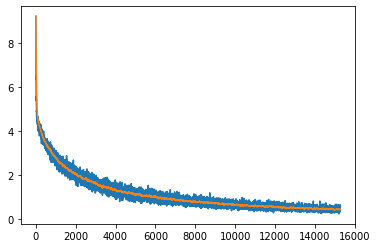

In [14]:
import numpy as np
import matplotlib.pyplot as plt

#loss_list = loss_records[:10000]
loss_list = loss_records

loss_average = []
for i in range(len(loss_list)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if i < 50:
        avg_list = loss_list[:i+1]
    else:
        avg_list = loss_list[i-49:i+1]
    loss_average.append(np.average(avg_list))
plt.plot(loss_list)
plt.plot(loss_average)

## Translate Text

Now translate text (French) to English with trained model.<br>
Here I simply translate several sentences. (All these sentences are not in training set.)

The metrics to evaluate text generation task is not so easy. (Because simply checking an exact match to a reference text is not optimal.)<br>
Use some common metrics available in these cases, such as, BLEU or ROUGE.

> Note : Here I use greedy search and this will sometimes lead to wrong sequence. For drawbacks and solutions, see note in [this example](./05_language_model_basic.ipynb).

In [15]:
import numpy as np

def translate(sentence):
    # preprocess french
    input_text_fr = sentence
    input_text_fr = input_text_fr.lower()
    input_text_fr = " ".join(["[START]", input_text_fr, "[END]"])

    text_seq_fr = source_vectorization(input_text_fr)
    text_seq_fr = tf.expand_dims(text_seq_fr, axis=0)

    # process encoder
    enc_outputs = enc_model(text_seq_fr)

    # process decoder
    vocab_list_en = target_vectorization.get_vocabulary()
    states = None
    prev_idx_en = target_vectorization("[START]")
    end_num_en = target_vectorization("[END]").numpy().tolist()[0]
    #text_seq_en = []
    #text_seq_en = tf.expand_dims(text_seq_en[len(text_seq_en) - 1], axis=0)
    while True:
        y, mask, states = dec_model(
            (tf.expand_dims(prev_idx_en, axis=0), enc_outputs),
            states=states,
            return_state=True)
        prev_idx_en = np.argmax(y[0][0])
        if prev_idx_en.item() == end_num_en:
            break
        print(vocab_list_en[prev_idx_en.item()], end=" ")
        prev_idx_en = tf.convert_to_tensor([prev_idx_en])
    print("\n")

In [16]:
translate("j'aime la guitare") # i like guitar
translate("il vit au japon") # he lives in Japan
translate("ce stylo est utilisé par lui") # this pen is used by him
translate("c'est ma chanson préférée") # that's my favorite song
translate("il conduit une voiture et va à new york") # he drives a car and goes to new york

i like the guitar 

he lives in japan 

this pen is next to his way 

this is my favorite song 

he drives a car and a cheap store 

